In [25]:
%run "lib.py"
%run "libplot.py"

## Simulate a circular orbit

maxR:80000.0
minR:79997.69664109554


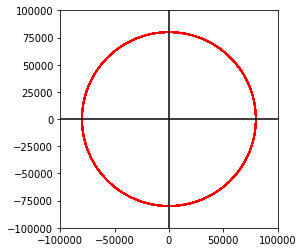

In [26]:
util = KerbinOrbitalUtilities;

radius = 80000;

initialPosition = Vector2(0, radius);

initialVelocity = Vector2(-util.circularOrbitSpeed(radius), 0);

sim = PathToOrbitSimulator(util);

result = sim.runSimulation(initialPosition, initialVelocity, lambda p, v : Vector2.ZERO, 1, lambda time, state : time < 3000);

maxR = initialPosition.magnitude();
minR = initialPosition.magnitude();

for state in result:
    r = state.position.magnitude();
    if r > maxR:
        maxR = r;

    if r < minR:
        minR = r;

print("maxR:" + str(maxR))
print("minR:" + str(minR))

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = plt.axes()
ax.set_aspect('equal')

plot_states(ax, result, 'red');

ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')

plt.xlim([-100000, 100000])
plt.ylim([-100000,100000])

plt.show()

## Simulate a realistic final ascent by starting from a circular orbit and integrating backwards in time

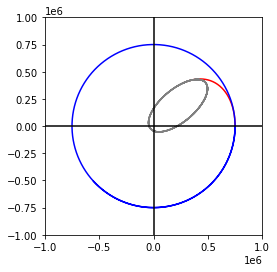

initialPosition = Vector2(286548.56505299004,402609.10482324107)
initialVelocity = Vector2(1749.7803259778643,728.9218759290676)


In [27]:
targetOrbitalRadius = 750000;

util = KerbinOrbitalUtilities;

initialEnergy = -5354477;

finalPosition = Vector2(targetOrbitalRadius, 0);
finalVelocity = Vector2(0, -util.circularOrbitSpeed(targetOrbitalRadius));

sim = PathToOrbitSimulator(util);

acceleration = 4;

result = sim.runSimulation(finalPosition, finalVelocity, lambda p, v: v.unit() * acceleration, -1, lambda t, s: util.specificOrbitalEnergyS(s) > initialEnergy)

initialState = result[-1]

startingOrbit = sim.runSimulation(initialState.position, initialState.velocity, lambda p, v : Vector2.ZERO, 0.6, lambda t, s : t < 3000)

finalOrbit = sim.runSimulation(result[0].position, result[0].velocity, lambda p, v : Vector2.ZERO, 0.6, lambda t, s : t < 3000)

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = plt.axes()
ax.set_aspect('equal')

plot_states(ax, result, 'red');
plot_states(ax, startingOrbit, 'grey');
plot_states(ax, finalOrbit, 'blue');

ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')

plt.xlim([-1000000, 1000000])
plt.ylim([-1000000,1000000])

plt.show()

initialPosition = initialState.position
initialVelocity = initialState.velocity

print("initialPosition = " + str(initialState.position))
print("initialVelocity = " + str(initialState.velocity))

## Simulate an ascent

In [28]:
def simulate_ascent(initialPosition, initialVelocity, sim, initialLerp, finalLerp, scale, slope):
    startingR = initialPosition.magnitude()
    finalR = targetOrbitalRadius

    gradientLerp = (initialLerp - finalLerp)/(startingR - finalR)
    cLerp = (finalLerp * startingR - initialLerp * finalR) / (startingR - finalR)

    def accelerationFunction(R):
        candidate = scale * acceleration * ( (slope + gradientLerp) * R + cLerp)
        candidate = max(0, candidate)
        candidate = min(30, candidate)
        return candidate

    timestep = 0.3
    
    def velocityFunction(p, v):
        suggestedAcceleration = accelerationFunction(p.magnitude())

        return v.unit() * suggestedAcceleration
        
        
    def binarySearchForTargetEnergy(state, thrust):
        startOfRange = 0;
        endOfRange = timestep;
        energyAtStartOfRange = util.specificOrbitalEnergyS(state)
        energyAtEndOfRange = util.specificOrbitalEnergyS(sim.simulateTimeStep(state, thrust, timestep))
        
        minEnergy = util.specificOrbitalEnergyOfCircularOrbit(targetOrbitalRadius - 0.1)
        maxEnergy = util.specificOrbitalEnergyOfCircularOrbit(targetOrbitalRadius + 0.1)
        
        if energyAtStartOfRange > maxEnergy or energyAtEndOfRange < minEnergy:
            raise "error"
        
        while True:
            midpoint = (endOfRange + startOfRange) / 2
            stateAtMidpoint = sim.simulateTimeStep(state, thrust, midpoint)
            energyAtMidpoint = util.specificOrbitalEnergyS(stateAtMidpoint)
            if energyAtMidpoint < minEnergy:
                startOfRange = midpoint
            elif energyAtMidpoint > maxEnergy:
                endOfRange = midpoint
            else:
                return stateAtMidpoint

    result = sim.runSimulation(initialPosition, initialVelocity, velocityFunction, timestep, lambda t, s: util.specificOrbitalEnergyS(s) < util.specificOrbitalEnergyOfCircularOrbit(targetOrbitalRadius))

    result.append(binarySearchForTargetEnergy(result[-1], velocityFunction))
    
    initialState = result[0]
    finalState = result[-1]

    startingOrbit = sim.runSimulation(initialState.position, initialState.velocity, lambda p, v : Vector2.ZERO, 1, lambda t, s : t < 2000)

    finalOrbit = sim.runSimulation(finalState.position, finalState.velocity, lambda p, v : Vector2.ZERO, 1, lambda t, s : t < 2000)

    import matplotlib as mpl
    import matplotlib.pyplot as plt
    import numpy as np

    fig1, axs1 = plt.subplots(1, 4, layout='constrained', figsize=(20, 5))
    fig2, axs2 = plt.subplots(1, 4, layout='constrained', figsize=(20, 15))
    positionPlot = axs1[0]
    acc = axs1[1]
    radiusOverTime = axs1[2]
    radiusOverTimeZoom = axs1[3]
    ellipse = axs2[0]
    ellipseZoomed = axs2[1]
    ellipseMegaZoom = axs2[2]
    emmz = axs2[3]

    plot_states(positionPlot, result, 'red');
    plot_states(positionPlot, startingOrbit, 'grey');
    plot_states(positionPlot, finalOrbit, 'blue');
    draw_axes(positionPlot)
    positionPlot.set_xlim([-1000000, 1000000])
    positionPlot.set_ylim([-1000000,1000000])
    plot_radius(radiusOverTime, result, 'red')
    radiusOverTime.axhline(y=targetOrbitalRadius, color='k')
    plot_radius(radiusOverTimeZoom, result, 'red')
    radiusOverTimeZoom.axhline(y=targetOrbitalRadius, color='k')
    radiusOverTimeZoom.set_ylim([targetOrbitalRadius - 10000,targetOrbitalRadius + 10000])
    


    plot_radius_and_e(ellipseZoomed, result, util, 'red')
    plot_ellipse_parameters(ellipseZoomed, result, util, 'green', targetOrbitalRadius)
    ellipseZoomed.set_xlim([-0.01, 0.09])
    ellipseZoomed.set_ylim([targetOrbitalRadius * (1-1/50), targetOrbitalRadius * (1 + 1/50)])
    plot_radius_and_e(ellipseMegaZoom, result, util, 'red')
    plot_ellipse_parameters(ellipseMegaZoom, result, util, 'green', targetOrbitalRadius)
    ellipseMegaZoom.set_xlim([-0.001, 0.009])
    ellipseMegaZoom.set_ylim([targetOrbitalRadius * (1-1/10000), targetOrbitalRadius * (1 + 1/10000)])
    plot_radius_and_e(emmz, result, util, 'red')
    plot_ellipse_parameters(emmz, result, util, 'green', targetOrbitalRadius)
    emmz.set_xlim([-0.0001, 0.0009])
    emmz.set_ylim([targetOrbitalRadius * (1-1/200000), targetOrbitalRadius * (1 + 1/200000)])
    plot_radius_and_e(ellipse, result, util, 'red')
    plot_ellipse_parameters(ellipse, result, util, 'green', targetOrbitalRadius)
    ellipse.set_xlim([-0.1, 1])
    ellipse.set_ylim([0, targetOrbitalRadius * 1.1])

    finalE = util.eccentricityS(finalState)
    finalA = util.semiMajorAxisS(finalState)
    finalAp = (1 + finalE) * finalA
    finalPe = (1 - finalE) * finalA
    print("Ap: " + str(finalAp))
    print("Pe: " + str(finalPe))
    
    minE = 1
    for state in result:
        minE = min(minE, util.eccentricityS(state))
    
    print("minE: " + str(minE))

    plot_acceleration_function(acc, startingR, finalR, accelerationFunction, acceleration)
    acc.set_ylim([-1, 30])


## Interactive Sim

In [29]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets

def f(px, py, aic, aif, aiff, afc, aff, afff, sc, sf, sff, slc, slf, slff):
    positionPerturbation = Vector2(px, py)
    initialLerp = aic + aif/5000.0 + aiff/1250000
    finalLerp = afc + aff /5000.0 + afff/1250000
    
    scale = sc + sf/5000.0 + sff/1250000
    slope = (slc + slf/5000.0 + slff/1250000)/100000

    simulate_ascent(initialPosition + positionPerturbation, initialVelocity, sim, initialLerp, finalLerp, scale, slope)

def fineSlider():
    return widgets.IntSlider(min=-250, max=250, step=1, value=0, layout=Layout(width='100%'))

def superFineSlider():
    return widgets.IntSlider(min=-250, max=250, step=1, value=0, layout=Layout(width='100%'))
    
def coarseSlider():
    return widgets.FloatSlider(min=-5, max=5, step=0.05, value=1, layout=Layout(width='100%'))
    
interact(f, px=widgets.IntSlider(min=-10000, max=10000, step=1, value=0),
         py=widgets.IntSlider(min=-10000, max=10000, step=1, value=0),
         aic=coarseSlider(), 
         aif=fineSlider(),
         aiff=superFineSlider(),
         afc=coarseSlider(),
         aff=fineSlider(),
         afff=superFineSlider(),
         sc=coarseSlider(),
         sf=fineSlider(),
         sff=superFineSlider(),
         slc=coarseSlider(),
         slf=fineSlider(),
         slff=superFineSlider()
        )

interactive(children=(IntSlider(value=0, description='px', max=10000, min=-10000), IntSlider(value=0, descript…

<function __main__.f(px, py, aic, aif, aiff, afc, aff, afff, sc, sf, sff, slc, slf, slff)>